In [167]:
from keras.models import Sequential
from keras.layers import Conv2D, Input, BatchNormalization
# from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint
from keras.optimizers import SGD, Adam
import prepare_data as pd
import numpy
import math
import scipy.misc as spm

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from PIL import Image

from lr_multiplier import LearningRateMultiplier

In [ ]:
def psnr(target, ref):
    # assume RGB image
    target_data = numpy.array(target, dtype=float)
    ref_data = numpy.array(ref, dtype=float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(numpy.mean(diff ** 2.))

    return 20 * math.log10(255. / rmse)

In [185]:
def model():
    multipliers = {'conv2d_1': 1, 'conv2d_2': 1, 'conv2d_3': 0.1}
    opt = LearningRateMultiplier(SGD, lr_multipliers=multipliers, lr=0.0001)
    
    # lrelu = LeakyReLU(alpha=0.1)
    sgd = SGD(lr=0.0001)
    
    SRCNN = Sequential()
    SRCNN.add(Conv2D(nb_filter=128, nb_row=9, nb_col=9, init='glorot_uniform',
                     activation='relu', border_mode='valid', bias=True, input_shape=(32, 32, 1), name='conv2d_1'))
    
    #Added by ferseiti
    SRCNN.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    SRCNN.add(Conv2D(nb_filter=64, nb_row=3, nb_col=3, init='glorot_uniform',
                     activation='relu', border_mode='same', bias=True, name='conv2d_2'))
    
    #Added by ferseiti
    SRCNN.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    # SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(nb_filter=1, nb_row=5, nb_col=5, init='glorot_uniform',
                     activation='linear', border_mode='valid', bias=True,  name='conv2d_3'))
    #adam = Adam(lr=0.0003)
    sgd_last = SGD(lr=0.00001)

#     SRCNN.compile(optimizer=sgd_last, loss='mean_squared_error', metrics=['mean_squared_error'])
    SRCNN.compile(optimizer=opt, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN

In [2]:
def predict_model():
    # lrelu = LeakyReLU(alpha=0.1)
    sgd = SGD(lr=0.0001)
    
    SRCNN = Sequential()
    SRCNN.add(Conv2D(nb_filter=128, nb_row=9, nb_col=9, init='glorot_uniform',
                     activation='relu', border_mode='valid', bias=True, input_shape=(None, None, 1)))
    
    SRCNN.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    SRCNN.add(Conv2D(nb_filter=64, nb_row=3, nb_col=3, init='glorot_uniform',
                     activation='relu', border_mode='same', bias=True))
    
    SRCNN.compile(optimizer=sgd, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    # SRCNN.add(BatchNormalization())
    SRCNN.add(Conv2D(nb_filter=1, nb_row=5, nb_col=5, init='glorot_uniform',
                     activation='linear', border_mode='valid', bias=True))
#     adam = Adam(lr=0.0003)
    sgd_last = SGD(lr=0.00001)
    SRCNN.compile(optimizer=sgd_last, loss='mean_squared_error', metrics=['mean_squared_error'])
    return SRCNN

In [170]:
def train():
    srcnn_model = model()
    print(srcnn_model.summary())
    data, label = pd.read_training_data("./train.h5")
    val_data, val_label = pd.read_training_data("./test.h5")

    checkpoint = ModelCheckpoint("SRCNN_check.h5", monitor='val_loss', verbose=1, save_best_only=True,
                                 save_weights_only=False, mode='min')
    callbacks_list = [checkpoint]

    srcnn_model.fit(data, label, batch_size=128, validation_data=(val_data, val_label),
                    callbacks=callbacks_list, shuffle=True, nb_epoch=200, verbose=0)
    # srcnn_model.load_weights("m_model_adam.h5")

In [164]:
def predict():
    srcnn_model = predict_model()
    srcnn_model.load_weights("3051crop_weight_200.h5")
    IMG_NAME = numpy.fromfile('/home/ferseiti/unicamp/ia369z/SRCNN-keras/ground_data/Palito/recon/slice_256.b',
                              dtype = 'uint8')
    INPUT_NAME = numpy.fromfile("/home/ferseiti/unicamp/ia369z/SRCNN-keras/sub_data/Palito_sub/recon/slice_128.b",
                                dtype = 'uint8')
    OUTPUT_NAME = "pre2.png"

    dimension_img = int(IMG_NAME.shape[0]**(1/2))
    dimension_input = int(INPUT_NAME.shape[0]**(1/2))
    
    IMG_NAME = IMG_NAME.reshape((dimension_img, dimension_img))
    INPUT_NAME = INPUT_NAME.reshape((dimension_input, dimension_input))
    
    import cv2
    img = INPUT_NAME.copy()
    shape = IMG_NAME.shape
    Y_img = img.copy()
    Y_img = spm.imresize(Y_img, size=shape, interp='bicubic')
    bicubic = Y_img.copy()

    Y_img = Y_img.reshape((dimension_img, dimension_img, 1))
    
    for i in range(Y_img.shape[-1]):
        Y = numpy.zeros((1, shape[0], shape[1], 1), dtype=float)
        Y[0,:,:,0] = Y_img[:,:,i].astype(float) / 255.
        pre = srcnn_model.predict(Y, batch_size=1) * 255.
        
    pre[pre[:] > 255] = 255
    pre[pre[:] < 0] = 0
    pre = pre.astype(float)
    print(Y_img.shape, pre.shape)
    Y_img[6: -6, 6: -6, 0] = pre[0, :, :, 0].copy()
    cv2.imwrite(OUTPUT_NAME, Y_img)

    # psnr calculation:
    im1 = IMG_NAME
    im2 = bicubic
    im3 = cv2.imread(OUTPUT_NAME)[:,:,0]
    
    print(im1.shape, im2.shape, im3.shape)

    print ("bicubic:")
    print (cv2.PSNR(im1, im2))
    print ("SRCNN:")
    print (cv2.PSNR(im1, im3))
    
    import matplotlib.pyplot as plt
    print(im1.shape)
    plt.figure(figsize=[7,15])
    plt.subplot(311)
#     plt.imshow(im1[350:450,200:400])
    plt.title('Original')
    plt.imshow(im1[150:350,150:350])
    plt.subplot(312)
#     plt.imshow(im2[350:450,200:400])
    plt.title('Bicubic')    
    plt.imshow(im2[150:350,150:350])
    plt.subplot(313)
#     plt.imshow(im3[350:450,200:400])
    plt.title('SRCNN')
    plt.imshow(im3[150:350,150:350])
    plt.show()

In [186]:
train()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 128)       10496     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        73792     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 1)         1601      
Total params: 85,889
Trainable params: 85,889
Non-trainable params: 0
_________________________________________________________________
None


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", input_shape=(32, 32, 1..., name="conv2d_1", kernel_size=(9, 9), filters=128, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", name="conv2d_2", kernel_size=(3, 3), filters=64, padding="same", kernel_initializer="glorot_uniform", use_bias=True)`
  app.launch_new_instance()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="linear", name="conv2d_3", kernel_size=(5, 5), filters=1, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`


OSError: Unable to open file (unable to open file: name = './train.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", input_shape=(None, Non..., kernel_size=(9, 9), filters=128, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="relu", kernel_size=(3, 3), filters=64, padding="same", kernel_initializer="glorot_uniform", use_bias=True)`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(activation="linear", kernel_size=(5, 5), filters=1, padding="valid", kernel_initializer="glorot_uniform", use_bias=True)`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in Sci

(512, 512, 1) (1, 500, 500, 1)
(512, 512) (512, 512) (512, 512)
bicubic:
35.90928408119834
SRCNN:
34.18041162188652
(512, 512)


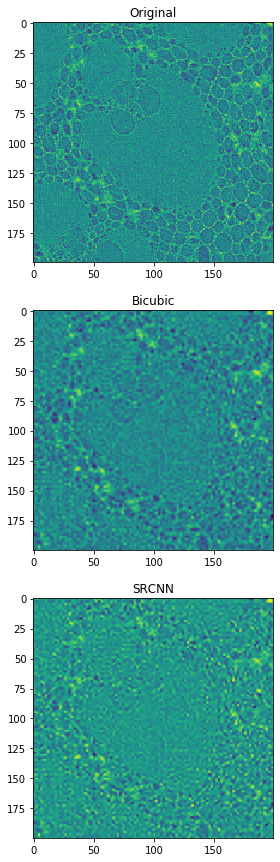

In [165]:
predict()

In [ ]:
a = mpimg.imread('butterfly_GT.bmp')
plt.imshow(a)
del(a)